In [1]:
# Import some basic libraries
import numpy as np

# These lines are for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('paper')
sns.set_style("ticks")

# The Uncertainty Propagation Problem

## Theoretical Objectives

+ To introduce the uncertainty propagation problem.

## Example: Driving a trailer on a rough road

The following example is modified from Purdue's Basic Mechanics II Lecture Book.
In the figure you see a trailer of mass m moving on a rough road with speed $v$.
The suspension spring constant is $k$.
We are intersted in the vibration amplitude $X$.

![Trailer](../images/trailer.png)

We do not know (yet) how we can model a true road, so let us assume that the road surface is sinusoidal with amplitude $y_0$ and "wavelength" $L$.
Doing a [little bit dynamics](https://www.youtube.com/watch?v=d4OKBqr_aYQ&feature=youtu.be), shows that the amplitude of the suspension oscilation is:

$$
X = \left|\frac{ky_0}{k-m\omega^2}\right|,
$$

where the angular velocity is:

$$
\omega = \frac{2\pi v}{L}.
$$

Let's draw the causal graph:

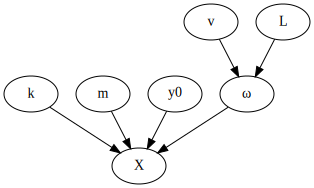

In [3]:
from graphviz import Digraph
g = Digraph('Trailer')
g.node('k')
g.node('m')
g.node('y0', label='<y<sub>0</sub>>')
g.node('omega', label='<&omega;>')
g.node('v')
g.node('L')
g.node('X')
g.edge('v', 'omega')
g.edge('L', 'omega')
g.edge('y0', 'X')
g.edge('omega', 'X')
g.edge('k', 'X')
g.edge('m', 'X')
#g.render('trailer_g', format='png')
g

### Questions

+ Which variables could be "known unknowns?" - m, k, y_0, v, L
+ Which of these are aleatory and which epistemic? - aleatory: v, y_0, L; epistemic: k, m
+ How can you reduce the epistemic uncertainty of some of these variables? - buy more expensive sensors or run more tests
+ What are some "unkown unknowns" that you could turn into "known unknowns?" - temperature, weather conditions, etc.

## The uncertainty propagation problem

As we mentioned earlier, both aleatory and epistemic uncertainties can be described using probability theory.
So, one of the first steps of predictive modeling is to come up with probability statementes for all uncertain variables.
However, this is also one of the most difficult problems...
So, let's assume that some has already done it for us.
The next step is to propagate this uncertainty through the causal model to characterize our uncertainty about a quantity of interest.
Let us do both using the trailer example.

### Solving uncertainty propagation problems

The simplest way to solve the uncertainty propagation problem is via sampling.
This is known as the *Monte Carlo* method. 
It was invented in Los Alamos during the Manhatan project.
We will study the Monte Carlo method extensively.
For now, let's look at a simple example.

### Example: Driving a trailer on a rough road (continued)

To make this more precise, assume that we are the manufacturer of the trailer.
Let's quantify our state of knowledge about all the parameters of this model using a little bit of common sense.

| Variable | Type | Values| 
|:---------|:--------------|:--------|
| k | Manufacturing uncertainty | [159,999, 160,001] N/m |
| v | Operating condition | [80, 150] km/hour |
| m | Loading condition | [100, 200] kg|
| y_0 | Road condition | [0, 100] mm|
| L | Road condition | [1, 2] m |

Not being able to come up with more precise information (or any data) we would consider any value within this intervals as equally likely.
Now, let's write some code to see how this uncertainty affects the angular velocity \omega and the amplitude X.

In [7]:
# The number of samples we wish to take
num_samples = 750
# Two arrays in which to store the samples we take
Xs = np.ndarray((num_samples, )) # To store the samples
omegas = np.ndarray((num_samples, ))
# Loop over samples
for i in range(num_samples):
    # Sampling the manufacturing uncertainty.
    k = 160000.0 + np.random.rand()
    # Note np.random.rand() samples a number uniformly between 0 and 1
    # The loading condition:
    m = 100.0 + (200.0 - 100.0) * np.random.rand()
    # Notice above how we transformed a number from [0, 1] to [100, 200]
    # We will revisit this later in the course.
    # The road condition.
    y0 = 100 * np.random.rand() * 1e-3
    # The operating condition.
    v = (80.0 + (150.0 - 80.0) * np.random.rand()) * 1e3 / 3600.0
    # The road condition.
    L = 1.0 + (2.0 - 1.0) * np.random.rand()
    # A sample of the angular velocity
    omega = 2.0 * np.pi * v / L
    # A sample of the amplitude
    X = np.abs(k * y0 / (k - m * omega ** 2))
    # Store the samples of angular velocity and amplitude in arrays
    omegas[i] = omega
    Xs[i] = X

Plot the normalized histogram of the angular velocity.

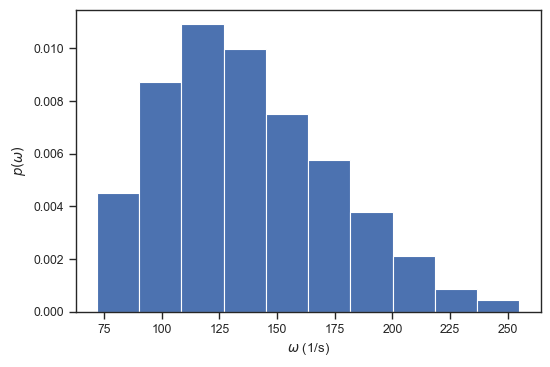

In [8]:
plt.hist(omegas, density=True)
plt.xlabel(r"$\omega$ (1/s)")
plt.ylabel(r"$p(\omega)$");

And here is the histogram of the amplitude.

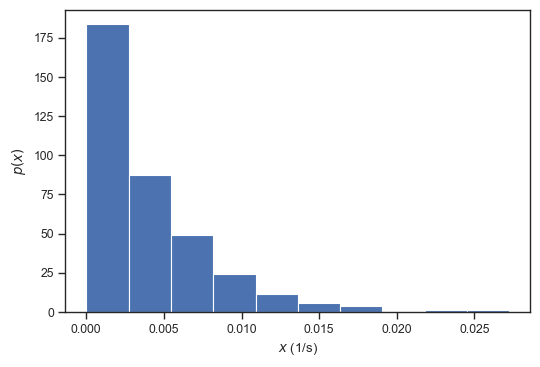

In [9]:
plt.hist(Xs, density=True)
plt.xlabel(r"$x$ (1/s)")
plt.ylabel(r"$p(x)$");

### Questions
+ What does the probability density in the figures above represent? Is the uncertainty aleatory or epistemic? The probability density in the figures above represents the different values that omega/X can take and their corresponding probabilities. From this, an expected value for each parameter can be calculated.
+ Rerun the code above giving different values to ``num_samples``. Can you trust the results when you pick small values? How can you pick the right value for ``num_samples``? You can't trust the results as much when the number of samples is small. You can pick the right value for number of samples by beginning with a small number, and increasing it such that the expected value of the desired parameters does not vary much.